In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU
from keras.layers.core import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from keras.utils import plot_model, to_categorical

Using TensorFlow backend.


In [2]:
df = pd.read_csv("FX_MA_5days.csv")
df.head()

,time,open,high,low,close,5mean,target
0,2016-11-07 07:00:00,104.101,104.630,103.779,104.476,103.6076,0
1,2016-11-08 07:00:00,104.462,105.194,104.297,105.176,103.8124,1
2,2016-11-09 07:00:00,105.178,105.890,101.193,105.658,104.2828,1
3,2016-11-10 07:00:00,105.685,106.949,104.960,106.816,105.0504,1
4,2016-11-11 07:00:00,106.796,106.934,106.032,106.683,105.7618,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 7 columns):
time      789 non-null object
open      789 non-null float64
high      789 non-null float64
low       789 non-null float64
close     789 non-null float64
5mean     789 non-null float64
target    789 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 43.3+ KB


In [4]:
split_data = '2019-05-06 06:00:00'
train, test = df[df['time'] < split_data], df[df['time'] >= split_data]

In [5]:
train = train.set_index('time')
test = test.set_index('time')

In [6]:
X_train = train.iloc[:,:5]
Y_train = train['target']

X_test = test.iloc[:,:5]
Y_test = test['target']

In [7]:
X_train = X_train.as_matrix()
print(X_train)
print("Data len: ",len(X_train))

X_test = X_test.as_matrix()
print(X_train)
print("Data len: ",len(X_test))

# 正規化
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train)

ms = MinMaxScaler()
X_test = ms.fit_transform(X_test)

[[104.101  104.63   103.779  104.476  103.6076]
 [104.462  105.194  104.297  105.176  103.8124]
 [105.178  105.89   101.193  105.658  104.2828]
 ...
 [111.425  111.613  111.05   111.385  111.5274]
 [111.382  111.666  111.354  111.51   111.512 ]
 [111.518  111.695  111.07   111.096  111.413 ]]
Data len:  650
[[104.101  104.63   103.779  104.476  103.6076]
 [104.462  105.194  104.297  105.176  103.8124]
 [105.178  105.89   101.193  105.658  104.2828]
 ...
 [111.425  111.613  111.05   111.385  111.5274]
 [111.382  111.666  111.354  111.51   111.512 ]
 [111.518  111.695  111.07   111.096  111.413 ]]
Data len:  139


/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/tim0114gap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [8]:
# Closeの値
X_train = X_train[:, 3]
X_test = X_test[:, 3]

In [9]:
Y_train = np.array(Y_train)
print("Y_train Target len: ",len(Y_train))

Y_test = np.array(Y_test)
print("Y_train Target len: ",len(Y_test))

Y_train Target len:  650
Y_train Target len:  139


In [10]:
maxlen = 5
dataTrain = []
targetTrain = []
for i in range(0, len(X_train) - maxlen):
    dataTrain.append(X_train[i: i + maxlen])
    targetTrain.append(Y_train[i + maxlen])

dataTest = []
targetTest = []
for i in range(0, len(X_test) - maxlen):
    dataTest.append(X_test[i: i + maxlen])
    targetTest.append(Y_test[i + maxlen])

In [11]:
X_train = np.array(dataTrain).reshape(len(dataTrain), 5, 1)
Y_train = np.array(targetTrain)

X_test = np.array(dataTest).reshape(len(dataTest), 5, 1)
Y_test = np.array(targetTest)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(645, 5, 1)
(645,)
(134, 5, 1)
(134,)


In [12]:
#Y_train = Y_train.reshape(len(Y_train), 1)
#Y_test = Y_test.reshape(len(Y_test), 1)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [13]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(645, 5, 1)
(645, 2)
(134, 5, 1)
(134, 2)


In [14]:
'''
モデル設定
'''
length_of_sequence = X_train.shape[1]  # 入力層 = 5
in_out_neurons = 2                     # 出力層 = 2
n_hidden = 100                         # 隠れ層 = 100

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, 1), return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(in_out_neurons))
model.add(Activation("softmax"))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizer, metrics=['acc'])

In [16]:
#plot_model(model, to_file='model.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_2 (Activation)    (None, 2)                 0         
Total params: 45,952
Trainable params: 45,952
Non-trainable params: 0
_________________________________________________________________


In [17]:
# コールバック指定（https://qiita.com/yukiB/items/f45f0f71bc9739830002）
early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='auto', patience=20)
history = model.fit(X_train, Y_train,
                  batch_size = 16, # 論文で使われるのが1, 32, 128, 256, 512
                  epochs=200,
                  validation_split=0.2,
                  callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 516 samples, validate on 129 samples
Epoch 1/200
516/516 [==============================] - 1s 3ms/step - loss: 0.7078 - acc: 0.5097 - val_loss: 0.6947 - val_acc: 0.5271
Epoch 2/200
516/516 [==============================] - 0s 501us/step - loss: 0.6947 - acc: 0.4922 - val_loss: 0.6926 - val_acc: 0.5504
Epoch 3/200
516/516 [==============================] - 0s 488us/step - loss: 0.6939 - acc: 0.5310 - val_loss: 0.6917 - val_acc: 0.5271
Epoch 4/200
516/516 [==============================] - 0s 497us/step - loss: 0.6930 - acc: 0.5310 - val_loss: 0.6918 - val_acc: 0.5271
Epoch 5/200
516/516 [==============================] - 0s 507us/step - loss: 0.6931 - acc: 0.4942 - val_loss: 0.6910 - val_acc: 0.5271
Epoch 6/200
516/516 [==============================] - 0s 499us/step - loss: 0.6920 - acc: 0.5310 - val_loss: 0.6910 - val_acc: 0.5271
Epoch 7/200
516/516 [==============================]

516/516 [==============================] - 0s 502us/step - loss: 0.4453 - acc: 0.7984 - val_loss: 0.4629 - val_acc: 0.7442
Epoch 59/200
516/516 [==============================] - 0s 501us/step - loss: 0.4319 - acc: 0.8023 - val_loss: 0.4529 - val_acc: 0.7597
Epoch 60/200
516/516 [==============================] - 0s 500us/step - loss: 0.4664 - acc: 0.7829 - val_loss: 0.4259 - val_acc: 0.8062
Epoch 61/200
516/516 [==============================] - 0s 502us/step - loss: 0.4368 - acc: 0.8120 - val_loss: 0.4202 - val_acc: 0.7907
Epoch 62/200
516/516 [==============================] - 0s 497us/step - loss: 0.4195 - acc: 0.8120 - val_loss: 0.4282 - val_acc: 0.8682
Epoch 63/200
516/516 [==============================] - 0s 511us/step - loss: 0.4293 - acc: 0.8178 - val_loss: 0.4099 - val_acc: 0.7907
Epoch 64/200
516/516 [==============================] - 0s 492us/step - loss: 0.4436 - acc: 0.7907 - val_loss: 0.4252 - val_acc: 0.8140
Epoch 65/200
516/516 [==============================] - 0s 51

516/516 [==============================] - 0s 494us/step - loss: 0.3832 - acc: 0.8217 - val_loss: 0.3890 - val_acc: 0.8527
Epoch 119/200
516/516 [==============================] - 0s 497us/step - loss: 0.3957 - acc: 0.8236 - val_loss: 0.4016 - val_acc: 0.8527
Epoch 120/200
516/516 [==============================] - 0s 502us/step - loss: 0.3887 - acc: 0.8178 - val_loss: 0.3682 - val_acc: 0.8450
Epoch 121/200
516/516 [==============================] - 0s 530us/step - loss: 0.3974 - acc: 0.8295 - val_loss: 0.3946 - val_acc: 0.8605
Epoch 122/200
516/516 [==============================] - 0s 530us/step - loss: 0.3832 - acc: 0.8236 - val_loss: 0.3680 - val_acc: 0.8605
Epoch 123/200
516/516 [==============================] - 0s 523us/step - loss: 0.3736 - acc: 0.8333 - val_loss: 0.3554 - val_acc: 0.8605
Epoch 124/200
516/516 [==============================] - 0s 519us/step - loss: 0.3771 - acc: 0.8411 - val_loss: 0.3879 - val_acc: 0.8527
Epoch 125/200
516/516 [==============================] 

Epoch 178/200
516/516 [==============================] - 0s 504us/step - loss: 0.3511 - acc: 0.8391 - val_loss: 0.3473 - val_acc: 0.8527
Epoch 179/200
516/516 [==============================] - 0s 518us/step - loss: 0.3396 - acc: 0.8469 - val_loss: 0.3359 - val_acc: 0.8682
Epoch 180/200
516/516 [==============================] - 0s 496us/step - loss: 0.3457 - acc: 0.8411 - val_loss: 0.3370 - val_acc: 0.8760
Epoch 181/200
516/516 [==============================] - 0s 499us/step - loss: 0.3446 - acc: 0.8391 - val_loss: 0.3390 - val_acc: 0.8527
Epoch 182/200
516/516 [==============================] - 0s 496us/step - loss: 0.3754 - acc: 0.8430 - val_loss: 0.3374 - val_acc: 0.8760
Epoch 183/200
516/516 [==============================] - 0s 538us/step - loss: 0.3378 - acc: 0.8585 - val_loss: 0.3478 - val_acc: 0.8682
Epoch 184/200
516/516 [==============================] - 0s 497us/step - loss: 0.3552 - acc: 0.8411 - val_loss: 0.3388 - val_acc: 0.8605
Epoch 185/200
516/516 [==================

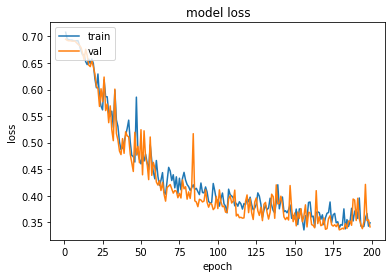

In [18]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

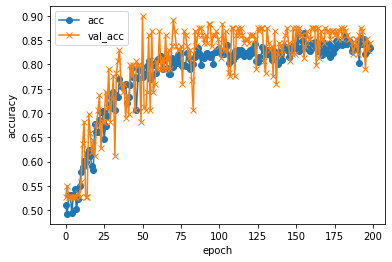

In [19]:
#acc, val_accのプロット
plt.plot(history.history["acc"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_acc"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
#Final.pngという名前で、結果を保存
# plt.savefig('Final.png')
# plt.show()

In [20]:
print("Test accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

134/134 [==============================] - 0s 114us/step
Test accuracy: 0.8209


In [21]:
predict_classes = model.predict_classes(X_test)

In [22]:
Y_test = np.array([np.argmax(x) for x in Y_test])

In [23]:
pd.crosstab(Y_test, predict_classes, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,49,16,65
1,8,61,69
All,57,77,134
